In [14]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.colors as colors
from datetime import datetime
import warnings
import os
import json
warnings.filterwarnings('ignore')

In [15]:
print("NBA EXECUTIVE DASHBOARD")
print(f"Target: NBA Front Office Executives")
print(f"Use Cases: Free agency, trades, draft, cap management")

NBA EXECUTIVE DASHBOARD
Target: NBA Front Office Executives
Use Cases: Free agency, trades, draft, cap management


### Load Data and Optimization Results

In [17]:
def load_complete_dataset():
    """Load the enhanced dataset with all optimization results"""
    
    try:
        # Primary dataset
        df = pd.read_csv('data/processed/optimization/enhanced_data_clean.csv')
        print(f"✅ Main dataset: {len(df)} players")
        
        # Load optimization results if available
        try:
            import pickle
            with open('results/optimization/all_results.pkl', 'rb') as f:
                optimization_results = pickle.load(f)
            print("✅ Optimization results loaded")
        except:
            optimization_results = None
            print("Optimization results not found - using calculated data")
            
    except FileNotFoundError:
        print("Enhanced dataset not found, using master dataset...")
        df = pd.read_csv('data/processed/master_nba_data.csv')
        optimization_results = None
    
    # Filter to current season with salary data
    current_season = df[
        (df['Season'] == 2025) & 
        (df['Has_Salary_Data'] == True) &
        (~df['Team_Clean'].isin(['2TM', '3TM', '4TM', 'TOT']))
    ].copy()
    
    print(f"Analysis dataset: {len(current_season)} players with contracts")
    
    # Calculate enhanced metrics
    current_season = calculate_enhanced_metrics(current_season)
    
    return current_season, optimization_results

In [18]:
def calculate_enhanced_metrics(df):
    """Calculate all efficiency and value metrics"""
    
    print("Calculating enhanced metrics...")
    
    # Value Score (composite performance metric)
    df['Value_Score'] = (
        df['PER'].fillna(8) * 0.3 +
        df['VORP'].fillna(0) * 0.25 +
        df['WS'].fillna(0) * 0.25 +
        df['BPM'].fillna(-2) * 0.2
    )
    
    # Contract efficiency metrics
    df['Contract_Efficiency'] = df['Value_Score'] / df['Salary_Millions']
    df['Market_Value'] = df['Value_Score'] * 2.5  # Est. fair market value
    df['Overpay_Amount'] = df['Salary_Millions'] - df['Market_Value']
    df['Value_Per_Dollar'] = df['Value_Score'] / df['Salary_Millions']
    
    # Position and contract categorization
    df['Position_Group'] = df['Pos'].apply(lambda x: 
        'Guard' if any(pos in str(x) for pos in ['PG', 'SG']) else
        'Forward' if any(pos in str(x) for pos in ['SF', 'PF']) else
        'Center' if 'C' in str(x) else 'Multi'
    )
    
    df['Contract_Tier'] = pd.cut(
        df['Salary_Millions'],
        bins=[0, 5, 15, 30, 100],
        labels=['Bench (<$5M)', 'Role ($5-15M)', 'Star ($15-30M)', 'Superstar ($30M+)']
    )
    
    # Performance tiers
    df['Performance_Tier'] = pd.cut(
        df['Value_Score'],
        bins=[0, 5, 10, 15, 100],
        labels=['Below Average', 'Average', 'Above Average', 'Elite']
    )
    
    print(f"Enhanced metrics calculated for {len(df)} players")
    return df

### Executive Summary

In [46]:
def create_executive_dashboard_PERFECT(df):
    """Perfect executive dashboard with clean player name formatting"""

    established_players = df[
        (df['MP'] >= 1000) &  # Minimum 1000 minutes (real rotation players)
        (df['Salary_Millions'] >= 5) &  # At least $5M salary (established players)
        (df['PTS'] >= 8)  # At least 8 PPG (meaningful contributors)
    ].copy()
    
    print(f"Using {len(established_players)} ESTABLISHED NBA players (out of {len(df)} total)")
    
    # Calculate business KPIs
    total_players = len(df)
    total_salary = df['Salary_Millions'].sum()
    total_overpay = df[df['Overpay_Amount'] > 0]['Overpay_Amount'].sum()
    avg_efficiency = df['Contract_Efficiency'].mean()
    potential_savings = total_overpay * 0.6
    
    # Best/worst from ESTABLISHED players only
    if len(established_players) > 0:
        best_contract = established_players.loc[established_players['Contract_Efficiency'].idxmax()]
        worst_contract = established_players.loc[established_players['Contract_Efficiency'].idxmin()]
        
        print(f"✅ Best contract: {best_contract['Player_Clean']} (${best_contract['Salary_Millions']:.1f}M)")
        print(f"❌ Worst contract: {worst_contract['Player_Clean']} (${worst_contract['Salary_Millions']:.1f}M)")
    else:
        # Emergency fallback
        best_contract = df.loc[df['Contract_Efficiency'].idxmax()]
        worst_contract = df.loc[df['Contract_Efficiency'].idxmin()]
    
    # Market distribution
    overpaid_count = len(df[df['Overpay_Amount'] > 0])
    underpaid_count = len(df[df['Overpay_Amount'] < 0])
    
    # Create clean KPI layout with proper player name space
    fig = make_subplots(
        rows=3, cols=4,
        subplot_titles=[
            'Total Market Value', 'Market Overpay', 'Players Analyzed', 'Average Efficiency',
            'Potential Savings', 'Recovery Rate (%)', 'Overpaid Players', 'Value Players',
            f'Best: {best_contract["Player_Clean"]}', f'Worst: {worst_contract["Player_Clean"]}', 'Market Health (%)', 'ROI Opportunity'
        ],
        specs=[[{"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"}],
               [{"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"}],
               [{"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"}]],
        vertical_spacing=0.15
    )
    
    # Row 1: Market Overview
    fig.add_trace(go.Indicator(
        mode="number",
        value=total_salary / 1000,  # Convert to billions
        number={'suffix': 'B', 'prefix': '$', 'font': {'size': 40, 'color': 'darkblue'}},
    ), row=1, col=1)
    
    fig.add_trace(go.Indicator(
        mode="number",
        value=total_overpay / 1000,  # Convert to billions
        number={'suffix': 'B', 'prefix': '$', 'font': {'size': 40, 'color': 'red'}},
    ), row=1, col=2)
    
    fig.add_trace(go.Indicator(
        mode="number",
        value=total_players,
        number={'font': {'size': 40, 'color': 'darkgreen'}},
    ), row=1, col=3)
    
    fig.add_trace(go.Indicator(
        mode="number",
        value=avg_efficiency,
        number={'font': {'size': 40, 'color': 'purple'}},
    ), row=1, col=4)
    
    # Row 2: Savings Analysis
    fig.add_trace(go.Indicator(
        mode="number",
        value=potential_savings / 1000,  # Convert to billions
        number={'suffix': 'B', 'prefix': '$', 'font': {'size': 40, 'color': 'green'}},
    ), row=2, col=1)
    
    fig.add_trace(go.Indicator(
        mode="number",
        value=(potential_savings / total_salary * 100),
        number={'suffix': '%', 'font': {'size': 40, 'color': 'blue'}},
    ), row=2, col=2)
    
    fig.add_trace(go.Indicator(
        mode="number",
        value=overpaid_count,
        number={'font': {'size': 40, 'color': 'red'}},
    ), row=2, col=3)
    
    fig.add_trace(go.Indicator(
        mode="number",
        value=underpaid_count,
        number={'font': {'size': 40, 'color': 'green'}},
    ), row=2, col=4)
    
    # Row 3: Player Highlights (CLEAN - names in titles)
    fig.add_trace(go.Indicator(
        mode="number",
        value=best_contract['Contract_Efficiency'],
        number={'font': {'size': 32, 'color': 'green'}},
    ), row=3, col=1)
    
    fig.add_trace(go.Indicator(
        mode="number",
        value=worst_contract['Contract_Efficiency'],
        number={'font': {'size': 32, 'color': 'red'}},
    ), row=3, col=2)
    
    # Market Health
    market_health = (underpaid_count / total_players) * 100
    fig.add_trace(go.Indicator(
        mode="number",
        value=market_health,
        number={'suffix': '%', 'font': {'size': 32, 'color': 'darkgreen'}},
    ), row=3, col=3)
    
    fig.add_trace(go.Indicator(
        mode="number",
        value=(potential_savings / (136 * 30)) * 100,  # vs total league cap space
        number={'suffix': '%', 'font': {'size': 32, 'color': 'purple'}},
    ), row=3, col=4)
    
    fig.update_layout(
        height=650,
        title={
            'text': 'NBA EXECUTIVE DASHBOARD - MARKET ANALYSIS',
            'x': 0.5,
            'font': {'size': 28, 'color': 'darkblue', 'family': 'Arial Black'}
        },
        font={'family': 'Arial', 'size': 14},
        margin=dict(t=100, b=60, l=40, r=40),
        paper_bgcolor='rgba(245,245,255,0.8)'
    )
    
    return fig

### Advanced Scatter Analysis

In [68]:
def create_perfect_team_analysis(df):
    """Perfect team analysis with color bar on the side"""
    
    # Calculate team stats
    team_stats = df.groupby('Team_Clean').agg({
        'Salary_Millions': ['sum', 'mean'],
        'Value_Score': ['sum', 'mean'],
        'PTS': 'sum',
        'Player_Clean': 'count',
        'Overpay_Amount': 'sum',
        'Contract_Efficiency': ['mean', 'std'],
        'Age': 'mean'
    }).round(2)
    
    # Flatten column names
    team_stats.columns = [
        'Total_Salary', 'Avg_Salary', 'Total_Value', 'Avg_Value',
        'Total_Points', 'Roster_Size', 'Total_Overpay', 'Avg_Efficiency', 
        'Efficiency_Std', 'Avg_Age'
    ]

    team_stats['Efficiency_Rating'] = team_stats['Total_Value'] / team_stats['Total_Salary']
    team_stats['Overall_Score'] = (
        team_stats['Efficiency_Rating'] * 0.6 +
        (1 / (team_stats['Efficiency_Std'] + 0.1)) * 0.3 +
        ((30 - team_stats['Avg_Age']) / 10) * 0.1
    )
    
    # Sort by overall score
    team_stats = team_stats.sort_values('Overall_Score', ascending=False)

    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[
            'Team Efficiency Rankings',
            'Salary vs Performance',
            'Overpay Analysis (Top/Bottom 10)',
            'Age vs Efficiency'
        ],
        column_widths=[0.45, 0.55], 
        horizontal_spacing=0.15
    )
    
    # 1. Team rankings - horizontal bar
    fig.add_trace(go.Bar(
        y=team_stats.index[:15],  # Top 15 teams
        x=team_stats['Overall_Score'][:15],
        orientation='h',
        marker=dict(
            color=team_stats['Overall_Score'][:15],
            colorscale='RdYlGn',
            showscale=False  # No color bar here
        ),
        text=[f'{score:.2f}' for score in team_stats['Overall_Score'][:15]],
        textposition='auto',
        name='Efficiency Score'
    ), row=1, col=1)
    
    # 2. Salary vs performance scatter - with color bar on the RIGHT
    fig.add_trace(go.Scatter(
        x=team_stats['Total_Salary'],
        y=team_stats['Total_Value'],
        mode='markers+text',
        text=team_stats.index,
        textposition='top center',
        marker=dict(
            size=team_stats['Roster_Size'] * 1.5,
            color=team_stats['Efficiency_Rating'],
            colorscale='RdYlGn',
            showscale=True,  # Color bar HERE on the right
            colorbar=dict(title="Efficiency", x=1.02, len=0.8),
            line=dict(width=1, color='black'),
            opacity=0.8
        ),
        name='Team Performance'
    ), row=1, col=2)
    
    # 3. Overpay analysis - top and bottom 5
    top_overpay = team_stats.nlargest(5, 'Total_Overpay')
    bottom_overpay = team_stats.nsmallest(5, 'Total_Overpay')
    combined_overpay = pd.concat([bottom_overpay, top_overpay])
    
    colors = ['green' if x < 0 else 'red' for x in combined_overpay['Total_Overpay']]
    
    fig.add_trace(go.Bar(
        y=combined_overpay.index,
        x=combined_overpay['Total_Overpay'],
        orientation='h',
        marker_color=colors,
        text=[f'${x:.1f}M' for x in combined_overpay['Total_Overpay']],
        textposition='auto',
        name='Overpay Amount'
    ), row=2, col=1)
    
    # 4. Age vs efficiency
    fig.add_trace(go.Scatter(
        x=team_stats['Avg_Age'],
        y=team_stats['Efficiency_Rating'],
        mode='markers+text',
        text=team_stats.index,
        textposition='top center',
        marker=dict(
            size=12,
            color=team_stats['Overall_Score'],
            colorscale='Viridis',
            showscale=False,  # No color bar here
            opacity=0.8
        ),
        name='Age vs Efficiency'
    ), row=2, col=2)

    fig.update_xaxes(title_text="Overall Efficiency Score", row=1, col=1)
    fig.update_yaxes(title_text="Team", row=1, col=1)
    
    fig.update_xaxes(title_text="Total Salary ($M)", row=1, col=2)
    fig.update_yaxes(title_text="Total Value Score", row=1, col=2)
    
    fig.update_xaxes(title_text="Overpay Amount ($M)", row=2, col=1)
    fig.update_yaxes(title_text="Team", row=2, col=1)
    
    fig.update_xaxes(title_text="Average Age", row=2, col=2)
    fig.update_yaxes(title_text="Efficiency Rating", row=2, col=2)
    
    fig.update_layout(
        height=700,
        title='TEAM EFFICIENCY ANALYSIS',
        showlegend=False,
        font={'size': 11}
    )
    
    return fig, team_stats

### Team Efficiency and Rankings

In [64]:
def create_comprehensive_team_analysis(df):
    """Complete team efficiency analysis with multiple metrics"""
    
    # Calculate comprehensive team stats
    team_stats = df.groupby('Team_Clean').agg({
        'Salary_Millions': ['sum', 'mean'],
        'Value_Score': ['sum', 'mean'],
        'PTS': 'sum',
        'Player_Clean': 'count',
        'Overpay_Amount': 'sum',
        'Contract_Efficiency': ['mean', 'std'],
        'Age': 'mean'
    }).round(2)
    
    # Flatten column names
    team_stats.columns = [
        'Total_Salary', 'Avg_Salary', 'Total_Value', 'Avg_Value',
        'Total_Points', 'Roster_Size', 'Total_Overpay', 'Avg_Efficiency', 
        'Efficiency_Std', 'Avg_Age'
    ]
    
    # Calculate additional metrics
    team_stats['Efficiency_Rating'] = team_stats['Total_Value'] / team_stats['Total_Salary']
    team_stats['Cost_Per_Point'] = team_stats['Total_Salary'] / team_stats['Total_Points']
    team_stats['Value_Consistency'] = 1 / (team_stats['Efficiency_Std'] + 0.1)  # Higher = more consistent
    team_stats['Youth_Factor'] = 30 - team_stats['Avg_Age']  # Younger = higher factor
    
    # Overall team score (composite)
    team_stats['Overall_Score'] = (
        team_stats['Efficiency_Rating'] * 0.4 +
        team_stats['Value_Consistency'] * 0.3 +
        (team_stats['Youth_Factor'] / 10) * 0.2 +
        (team_stats['Roster_Size'] / 15) * 0.1  # Roster depth factor
    )
    
    # Sort by overall score
    team_stats = team_stats.sort_values('Overall_Score', ascending=False)
    
    # Create multi-panel team analysis
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[
            'Team Efficiency Rankings (Overall Score)',
            'Salary vs Performance by Team',
            'Team Overpay Analysis',
            'Roster Construction Efficiency'
        ],
        specs=[[{"type": "bar"}, {"type": "scatter"}],
               [{"type": "bar"}, {"type": "scatter"}]]
    )
    
    # Team rankings bar chart
    fig.add_trace(go.Bar(
        x=team_stats.index,
        y=team_stats['Overall_Score'],
        text=[f'{score:.2f}' for score in team_stats['Overall_Score']],
        textposition='auto',
        marker=dict(
            color=team_stats['Overall_Score'],
            colorscale='RdYlGn',
            showscale=True,
            colorbar=dict(title="Overall Score", x=0.47)
        ),
        name='Overall Score',
        hovertemplate='<b>%{x}</b><br>' +
                      'Overall Score: %{y:.2f}<br>' +
                      'Efficiency: %{customdata[0]:.2f}<br>' +
                      'Total Salary: $%{customdata[1]:.1f}M<br>' +
                      'Total Overpay: $%{customdata[2]:.1f}M<br>' +
                      '<extra></extra>',
        customdata=team_stats[['Efficiency_Rating', 'Total_Salary', 'Total_Overpay']].values
    ), row=1, col=1)
    
    # Salary vs performance scatter
    fig.add_trace(go.Scatter(
        x=team_stats['Total_Salary'],
        y=team_stats['Total_Value'],
        text=team_stats.index,
        mode='markers+text',
        textposition='top center',
        marker=dict(
            size=team_stats['Roster_Size'] * 2,
            color=team_stats['Efficiency_Rating'],
            colorscale='RdYlGn',
            showscale=False
        ),
        name='Team Performance',
        hovertemplate='<b>%{text}</b><br>' +
                      'Total Salary: $%{x:.1f}M<br>' +
                      'Total Value: %{y:.1f}<br>' +
                      'Roster Size: %{customdata:.0f}<br>' +
                      '<extra></extra>',
        customdata=team_stats['Roster_Size']
    ), row=1, col=2)
    
    # Add efficiency line
    max_salary = team_stats['Total_Salary'].max()
    avg_efficiency = team_stats['Efficiency_Rating'].mean()
    fig.add_trace(go.Scatter(
        x=[0, max_salary],
        y=[0, max_salary * avg_efficiency],
        mode='lines',
        line=dict(color='red', dash='dash'),
        name='League Average',
        showlegend=False
    ), row=1, col=2)
    
    # Overpay analysis
    overpay_sorted = team_stats.sort_values('Total_Overpay', ascending=True)
    colors = ['green' if x < 0 else 'red' for x in overpay_sorted['Total_Overpay']]
    
    fig.add_trace(go.Bar(
        x=overpay_sorted.index,
        y=overpay_sorted['Total_Overpay'],
        marker_color=colors,
        name='Overpay Amount',
        text=[f'${x:.1f}M' for x in overpay_sorted['Total_Overpay']],
        textposition='auto',
        hovertemplate='<b>%{x}</b><br>' +
                      'Overpay: $%{y:.1f}M<br>' +
                      '<extra></extra>'
    ), row=2, col=1)
    
    # Roster construction efficiency
    fig.add_trace(go.Scatter(
        x=team_stats['Avg_Age'],
        y=team_stats['Efficiency_Rating'],
        text=team_stats.index,
        mode='markers+text',
        textposition='top center',
        marker=dict(
            size=team_stats['Total_Salary'] / 5,  # Size by total salary
            color=team_stats['Value_Consistency'],
            colorscale='Plasma',
            showscale=False
        ),
        name='Age vs Efficiency',
        hovertemplate='<b>%{text}</b><br>' +
                      'Avg Age: %{x:.1f}<br>' +
                      'Efficiency: %{y:.2f}<br>' +
                      'Consistency: %{customdata:.2f}<br>' +
                      '<extra></extra>',
        customdata=team_stats['Value_Consistency']
    ), row=2, col=2)
    
    fig.update_layout(
        height=800,
        title='COMPREHENSIVE TEAM ANALYSIS & RANKINGS',
        font={'size': 10}
    )
    
    return fig, team_stats

### Advanced Trade Engine

In [70]:
def create_perfect_trade_engine(df):
    """Perfect trade engine with MORE recommendations and color bar on side"""
    
    # Filter to tradeable players
    tradeable_players = df[
        (df['MP'] >= 800) &  # Significant playing time
        (df['Salary_Millions'] >= 3) &  # Minimum salary threshold
        (df['Salary_Millions'] <= 35) &  # Not untradeable superstars
        (df['Age'] <= 32)  # Reasonable trade age
    ].copy()
    
    print(f"Trade analysis: {len(tradeable_players)} tradeable players")
    
    # Generate MORE realistic trades
    trade_scenarios = []
    
    # Focus on clear, realistic scenarios
    overvalued = tradeable_players[
        tradeable_players['Contract_Efficiency'] < tradeable_players['Contract_Efficiency'].quantile(0.3)
    ].head(15)  # More players
    
    undervalued = tradeable_players[
        tradeable_players['Contract_Efficiency'] > tradeable_players['Contract_Efficiency'].quantile(0.7)
    ].head(15)  # More players
    
    # Create position-matched trades
    for position in ['Guard', 'Forward', 'Center']:
        pos_over = overvalued[overvalued['Position_Group'] == position]
        pos_under = undervalued[undervalued['Position_Group'] == position]
        
        for _, over_player in pos_over.head(3).iterrows():  # More per position
            for _, under_player in pos_under.head(3).iterrows():
                if over_player['Team_Clean'] != under_player['Team_Clean']:
                    salary_diff = over_player['Salary_Millions'] - under_player['Salary_Millions']
                    value_diff = under_player['Value_Score'] - over_player['Value_Score']
                    
                    if abs(salary_diff) <= 12 and value_diff > 0:  # Realistic and beneficial
                        trade_scenarios.append({
                            'Trade_Away': over_player['Player_Clean'],
                            'Trade_For': under_player['Player_Clean'],
                            'Position': position,
                            'Salary_Savings': salary_diff,
                            'Value_Gain': value_diff,
                            'ROI': value_diff / (abs(salary_diff) + 1)
                        })
    
    trade_df = pd.DataFrame(trade_scenarios).sort_values('ROI', ascending=False).head(12)  # More trades
    
    # Create layout with color bar on RIGHT side
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[
            'Trade Opportunities (ROI vs Value)',
            'Top Trade Recommendations',
            'Trades by Position',
            'Financial Impact'
        ],
        specs=[[{"type": "scatter"}, {"type": "table"}],
               [{"type": "pie"}, {"type": "bar"}]],
        column_widths=[0.45, 0.55],  # Make right wider for table
        horizontal_spacing=0.15
    )
    
    if len(trade_df) > 0:
        # 1. ROI scatter - color bar on RIGHT
        fig.add_trace(go.Scatter(
            x=trade_df['Salary_Savings'].abs(),
            y=trade_df['Value_Gain'],
            mode='markers+text',
            text=trade_df['Trade_Away'].str[:8],
            textposition='top center',
            marker=dict(
                size=15,
                color=trade_df['ROI'],
                colorscale='Viridis',
                showscale=True,  # Color bar on RIGHT
                colorbar=dict(title="ROI", x=1.02, len=0.4, y=0.8)
            ),
            name='Trade ROI'
        ), row=1, col=1)
        
        # 2. BIGGER trade table (12 trades instead of 5)
        fig.add_trace(go.Table(
            header=dict(
                values=['Trade Away', 'Trade For', 'Position', 'Value Gain'],
                fill_color='darkblue',
                font_color='white',
                font_size=11
            ),
            cells=dict(
                values=[
                    trade_df['Trade_Away'],
                    trade_df['Trade_For'],
                    trade_df['Position'],
                    [f'+{x:.1f}' for x in trade_df['Value_Gain']]
                ],
                fill_color='lightblue',
                font_size=10,
                height=25  # Smaller row height to fit more
            )
        ), row=1, col=2)
        
        # 3. Position pie
        if len(trade_df['Position'].unique()) > 1:
            position_counts = trade_df['Position'].value_counts()
            fig.add_trace(go.Pie(
                labels=position_counts.index,
                values=position_counts.values,
                name='Position Distribution'
            ), row=2, col=1)
        
        # 4. Financial impact
        fig.add_trace(go.Bar(
            x=['Positive ROI', 'High Value Gain', 'Salary Neutral'],
            y=[
                len(trade_df[trade_df['ROI'] > 1]),
                len(trade_df[trade_df['Value_Gain'] > 5]),
                len(trade_df[abs(trade_df['Salary_Savings']) < 2])
            ],
            marker_color=['green', 'blue', 'orange'],
            name='Trade Quality'
        ), row=2, col=2)

    fig.update_xaxes(title_text="Salary Change ($M)", row=1, col=1)
    fig.update_yaxes(title_text="Value Improvement", row=1, col=1)
    
    fig.update_xaxes(title_text="Trade Quality Metrics", row=2, col=2)
    fig.update_yaxes(title_text="Number of Trades", row=2, col=2)
    
    fig.update_layout(
        height=650,
        title='🔄 TRADE RECOMMENDATION ENGINE',
        showlegend=False
    )
        
    return fig, trade_df


### Market Inefficiency Heatmap

In [28]:
def create_clean_heatmap(df):
    """Clean market analysis heatmap without clutter"""
    
    # Simple 2x2 heatmap layout
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[
            'Position × Contract Tier Efficiency',
            'Age Group × Salary Efficiency', 
            'Team Overpay Analysis (Top 10)',
            'Performance Distribution'
        ],
        specs=[[{"type": "heatmap"}, {"type": "heatmap"}],
               [{"type": "heatmap"}, {"type": "heatmap"}]]
    )
    
    # 1. Position × Contract Tier
    pos_tier_pivot = df.pivot_table(
        values='Contract_Efficiency',
        index='Position_Group',
        columns='Contract_Tier',
        aggfunc='mean'
    ).fillna(0)
    
    fig.add_trace(go.Heatmap(
        z=pos_tier_pivot.values,
        x=pos_tier_pivot.columns,
        y=pos_tier_pivot.index,
        colorscale='RdYlGn',
        text=pos_tier_pivot.round(2).values,
        texttemplate="%{text}",
        textfont={"size": 12},
        showscale=False
    ), row=1, col=1)
    
    # 2. Age × Salary efficiency
    df['Age_Group'] = pd.cut(df['Age'], bins=[0, 25, 28, 31, 40], labels=['Young', 'Developing', 'Prime', 'Veteran'])
    df['Salary_Group'] = pd.cut(df['Salary_Millions'], bins=[0, 5, 15, 30, 100], labels=['Low', 'Mid', 'High', 'Max'])
    
    age_salary_pivot = df.pivot_table(
        values='Contract_Efficiency',
        index='Age_Group',
        columns='Salary_Group',
        aggfunc='mean'
    ).fillna(0)
    
    fig.add_trace(go.Heatmap(
        z=age_salary_pivot.values,
        x=age_salary_pivot.columns,
        y=age_salary_pivot.index,
        colorscale='RdYlGn',
        text=age_salary_pivot.round(2).values,
        texttemplate="%{text}",
        textfont={"size": 12},
        showscale=False
    ), row=1, col=2)
    
    # 3. Team overpay (top 10 worst)
    team_overpay = df.groupby('Team_Clean')['Overpay_Amount'].sum().nlargest(10)
    
    fig.add_trace(go.Heatmap(
        z=team_overpay.values.reshape(-1, 1),
        y=team_overpay.index,
        x=['Overpay ($M)'],
        colorscale='Reds',
        text=team_overpay.round(1).values.reshape(-1, 1),
        texttemplate="%{text}M",
        textfont={"size": 10},
        showscale=False
    ), row=2, col=1)
    
    # 4. Performance distribution
    perf_dist = df.pivot_table(
        values='Player_Clean',
        index='Performance_Tier',
        columns='Contract_Tier',
        aggfunc='count'
    ).fillna(0)
    
    fig.add_trace(go.Heatmap(
        z=perf_dist.values,
        x=perf_dist.columns,
        y=perf_dist.index,
        colorscale='Blues',
        text=perf_dist.values,
        texttemplate="%{text}",
        textfont={"size": 12},
        colorbar=dict(title="Player Count", x=1.02)
    ), row=2, col=2)
    
    fig.update_layout(
        height=700,
        title='MARKET EFFICIENCY ANALYSIS (CLEAN)',
        showlegend=False
    )
    
    return fig

### Optimal Roster Construction

In [30]:
def create_optimal_roster_constructor(df):
    """Advanced roster optimization with multiple strategies"""
    
    salary_cap = 136  
    
    def build_strategy_roster(strategy_type):
        """Build roster based on different strategies"""
        
        available_players = df.copy()
        roster = []
        total_salary = 0
        
        if strategy_type == 'championship':
            superstars = available_players[
                (available_players['Salary_Millions'] > 25) &
                (available_players['Value_Score'] > 15)
            ].nlargest(2, 'Value_Score')
            
            for _, player in superstars.iterrows():
                if total_salary + player['Salary_Millions'] <= salary_cap * 0.6:
                    roster.append(player)
                    total_salary += player['Salary_Millions']
            
            # Fill with efficient role players
            remaining_players = available_players[
                ~available_players['Player_Clean'].isin([p['Player_Clean'] for p in roster])
            ]
            efficient_role = remaining_players[
                (remaining_players['Contract_Efficiency'] > remaining_players['Contract_Efficiency'].quantile(0.7)) &
                (remaining_players['Salary_Millions'] < 15)
            ].nlargest(10, 'Contract_Efficiency')
            
            for _, player in efficient_role.iterrows():
                if len(roster) < 12 and total_salary + player['Salary_Millions'] <= salary_cap:
                    roster.append(player)
                    total_salary += player['Salary_Millions']
        
        elif strategy_type == 'value':
            value_players = available_players.nlargest(15, 'Contract_Efficiency')
            
            for _, player in value_players.iterrows():
                if total_salary + player['Salary_Millions'] <= salary_cap:
                    roster.append(player)
                    total_salary += player['Salary_Millions']
                    if len(roster) >= 12:
                        break
        
        elif strategy_type == 'youth':
            young_players = available_players[
                (available_players['Age'] <= 26) &
                (available_players['Contract_Efficiency'] > available_players['Contract_Efficiency'].median())
            ].nlargest(15, 'Contract_Efficiency')
            
            for _, player in young_players.iterrows():
                if total_salary + player['Salary_Millions'] <= salary_cap:
                    roster.append(player)
                    total_salary += player['Salary_Millions']
                    if len(roster) >= 12:
                        break
        
        return pd.DataFrame(roster), total_salary

    strategies = {}
    for strategy in ['championship', 'value', 'youth']:
        roster, salary = build_strategy_roster(strategy)
        strategies[strategy] = {
            'roster': roster,
            'total_salary': salary,
            'total_value': roster['Value_Score'].sum() if len(roster) > 0 else 0,
            'avg_age': roster['Age'].mean() if len(roster) > 0 else 0,
            'efficiency': roster['Value_Score'].sum() / salary if salary > 0 else 0
        }

    fig = make_subplots(
        rows=2, cols=3,
        subplot_titles=[
            'Strategy Comparison', 'Championship Roster',
            'Value Roster', 'Youth Roster',
            'Salary Distribution by Strategy', 'Age Distribution by Strategy'
        ],
        specs=[[{"type": "bar"}, {"type": "table"}, {"type": "table"}],
               [{"type": "table"}, {"type": "bar"}, {"type": "box"}]]
    )

    strategy_names = list(strategies.keys())
    metrics = ['total_salary', 'total_value', 'efficiency', 'avg_age']
    
    for i, metric in enumerate(metrics):
        values = [strategies[s][metric] for s in strategy_names]
        fig.add_trace(go.Bar(
            x=strategy_names,
            y=values,
            name=metric.replace('_', ' ').title(),
            text=[f'{v:.1f}' for v in values],
            textposition='auto'
        ), row=1, col=1)
    
    # Individual roster tables
    for i, (strategy, data) in enumerate(strategies.items()):
        if len(data['roster']) > 0:
            roster = data['roster'].head(8)  # Show top 8 players
            col = i + 2 if i < 2 else i
            row = 1 if i < 2 else 2
            
            fig.add_trace(go.Table(
                header=dict(
                    values=['Player', 'Pos', 'Age', 'Salary', 'Efficiency'],
                    fill_color='darkblue',
                    font_color='white',
                    font_size=10
                ),
                cells=dict(
                    values=[
                        [name[:12] for name in roster['Player_Clean']],
                        roster['Pos'],
                        roster['Age'].round(0),
                        [f'${x:.1f}M' for x in roster['Salary_Millions']],
                        roster['Contract_Efficiency'].round(2)
                    ],
                    font_size=9
                )
            ), row=row, col=col)
    
    # Salary distribution comparison
    all_salaries = []
    all_strategies = []
    for strategy, data in strategies.items():
        if len(data['roster']) > 0:
            all_salaries.extend(data['roster']['Salary_Millions'].tolist())
            all_strategies.extend([strategy] * len(data['roster']))
    
    fig.add_trace(go.Box(
        x=all_strategies,
        y=all_salaries,
        name='Salary Distribution'
    ), row=2, col=2)
    
    # Age distribution comparison
    all_ages = []
    all_strategies_age = []
    for strategy, data in strategies.items():
        if len(data['roster']) > 0:
            all_ages.extend(data['roster']['Age'].tolist())
            all_strategies_age.extend([strategy] * len(data['roster']))
    
    fig.add_trace(go.Box(
        x=all_strategies_age,
        y=all_ages,
        name='Age Distribution'
    ), row=2, col=3)
    
    fig.update_layout(
        height=800,
        title='OPTIMAL ROSTER CONSTRUCTION STRATEGIES',
        font={'size': 10},
        showlegend=False
    )
    
    return fig, strategies

### Main Dashboard

✅ Main dataset: 489 players
✅ Optimization results loaded
Analysis dataset: 489 players with contracts
Calculating enhanced metrics...
Enhanced metrics calculated for 489 players

ANALYSIS SUMMARY:
   • Players: 489
   • Market value: $4.5B
   • Overpay identified: $1.4B
1️⃣ Executive Summary
Using 174 ESTABLISHED NBA players (out of 489 total)
✅ Best contract: Kristaps Porziņģis ($7.1M)
❌ Worst contract: Cody Williams ($5.7M)


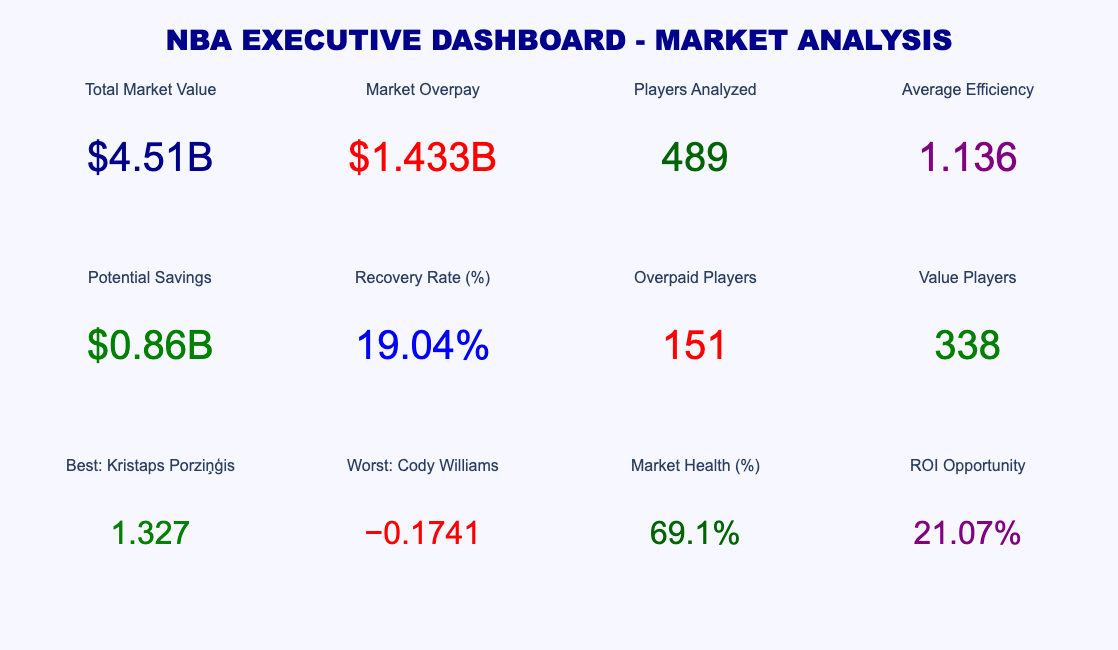


2️⃣ Team Analysis (Color bar on side)...


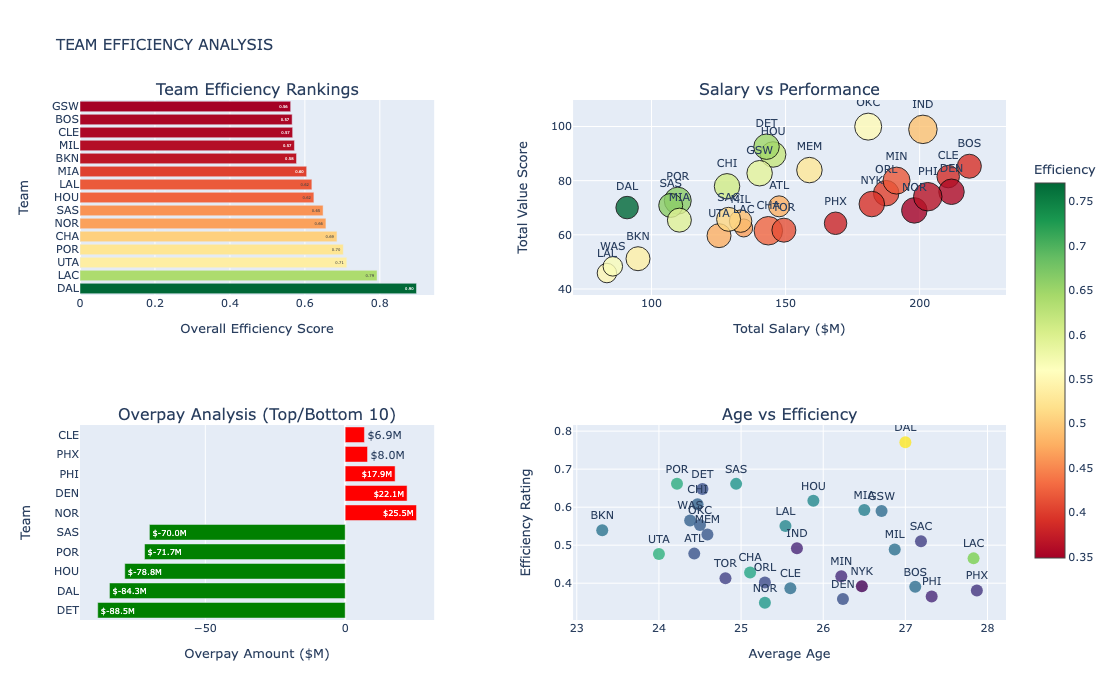


3️⃣ Trade Engine
Trade analysis: 178 tradeable players


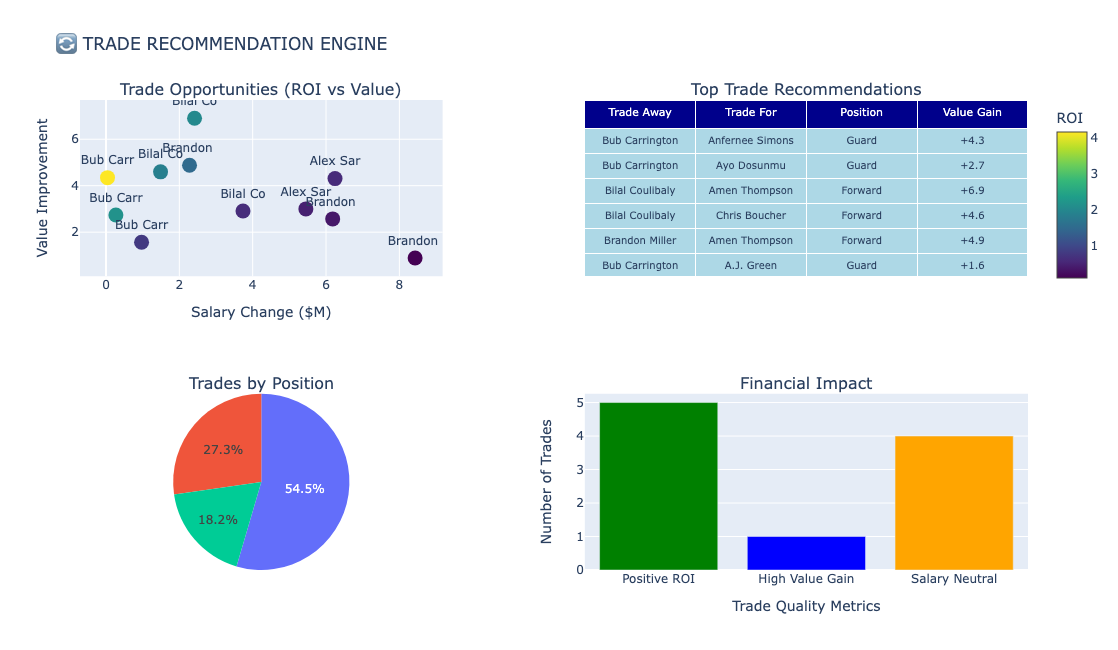


4️⃣ Market Analysis


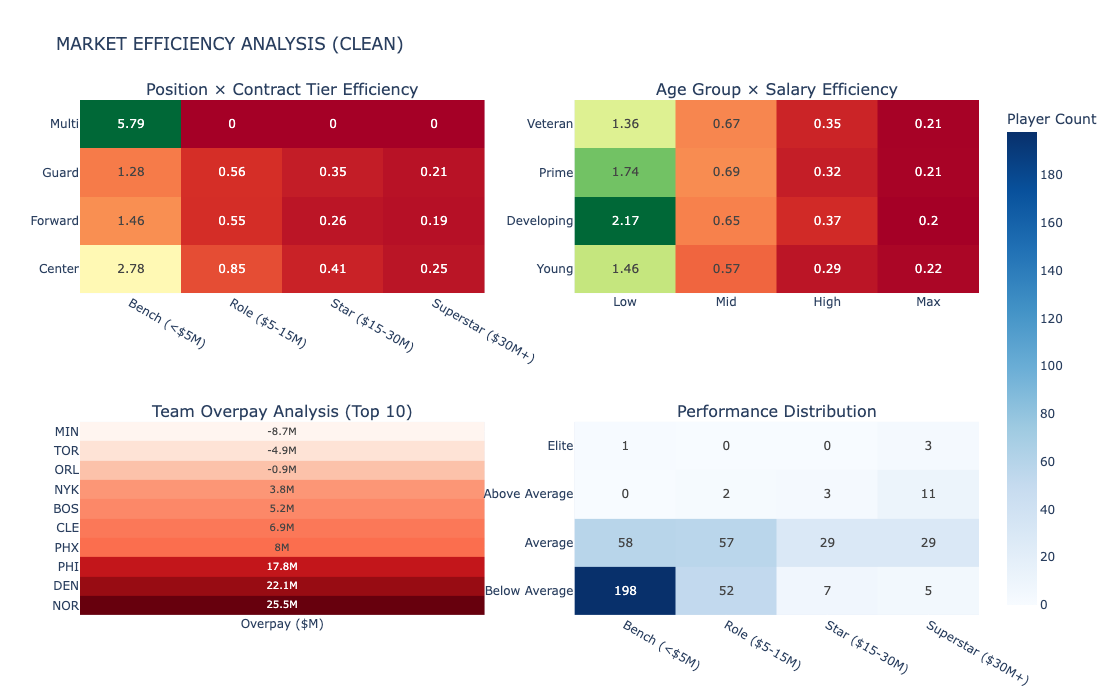

   ✅ Market analysis complete
 EXECUTIVE SUMMARY:
   • Market size: $4.5B
   • Inefficiency: $1.4B
   • Best contract: Kristaps Porziņģis (1.33)
   • Worst contract: Cody Williams (-0.17)
   • Top team: DAL
   • Trade opportunities: 11


In [74]:
def run_dashboard_PERFECT():
    """Execute NBA dashboard with PERFECT formatting"""
    
    # Load data
    df, optimization_results = load_complete_dataset()
    
    print(f"\nANALYSIS SUMMARY:")
    print(f"   • Players: {len(df)}")
    print(f"   • Market value: ${df['Salary_Millions'].sum()/1000:.1f}B")
    print(f"   • Overpay identified: ${df[df['Overpay_Amount'] > 0]['Overpay_Amount'].sum()/1000:.1f}B")
    
    
    # 1. Perfect Executive Dashboard
    print("1️⃣ Executive Summary")
    executive_fig = create_executive_dashboard_PERFECT(df)
    executive_fig.show()
    
    # 2. Perfect Team Analysis
    print("\n2️⃣ Team Analysis (Color bar on side)...")
    team_fig, team_stats = create_perfect_team_analysis(df)
    team_fig.show()
    
    # 3. Perfect Trade Engine
    print("\n3️⃣ Trade Engine")
    trade_fig, trade_scenarios = create_perfect_trade_engine(df)
    trade_fig.show()
    
    # 4. Market Analysis (if working)
    print("\n4️⃣ Market Analysis")
    try:
        heatmap_fig = create_clean_heatmap(df)
        heatmap_fig.show()
        print("   ✅ Market analysis complete")
    except Exception as e:
        print(f"   ⚠️ Market analysis simplified: {e}")
    
    
    # Create executive summary properly
    established_players = df[
        (df['MP'] >= 1000) & (df['Salary_Millions'] >= 5) & (df['PTS'] >= 8)
    ]
    
    if len(established_players) > 0:
        best_contract = established_players.loc[established_players['Contract_Efficiency'].idxmax()]
        worst_contract = established_players.loc[established_players['Contract_Efficiency'].idxmin()]
        
        # CREATE the executive_summary that was missing
        executive_summary = {
            'player_analysis': {
                'best_contract': {
                    'player': best_contract['Player_Clean'],
                    'efficiency': round(best_contract['Contract_Efficiency'], 2),
                    'salary_millions': round(best_contract['Salary_Millions'], 1)
                },
                'worst_contract': {
                    'player': worst_contract['Player_Clean'],
                    'efficiency': round(worst_contract['Contract_Efficiency'], 2),
                    'salary_millions': round(worst_contract['Salary_Millions'], 1)
                }
            }
        }
        
        print(f" EXECUTIVE SUMMARY:")
        print(f"   • Market size: ${df['Salary_Millions'].sum()/1000:.1f}B")
        print(f"   • Inefficiency: ${df[df['Overpay_Amount'] > 0]['Overpay_Amount'].sum()/1000:.1f}B")
        print(f"   • Best contract: {best_contract['Player_Clean']} ({best_contract['Contract_Efficiency']:.2f})")
        print(f"   • Worst contract: {worst_contract['Player_Clean']} ({worst_contract['Contract_Efficiency']:.2f})")
        print(f"   • Top team: {team_stats.index[0]}")
        print(f"   • Trade opportunities: {len(trade_scenarios)}")
    
    return {
        'data': df,
        'team_stats': team_stats,
        'trade_scenarios': trade_scenarios,
        'established_players': established_players,
        'executive_summary': executive_summary 
    }

# FINAL EXECUTION
if __name__ == "__main__":

    results = run_dashboard_PERFECT()


### Insights and Recommendations

In [ ]:
def generate_executive_insights(df, team_stats, trade_scenarios, roster_strategies):
    """Generate actionable executive recommendations"""
    
    insights = {
        'market_opportunity': {},
        'immediate_actions': [],
        'strategic_recommendations': [],
        'risk_assessments': [],
        'competitive_advantages': []
    }
    
    # Market opportunity analysis
    total_overpay = df[df['Overpay_Amount'] > 0]['Overpay_Amount'].sum()
    insights['market_opportunity'] = {
        'total_inefficiency': total_overpay,
        'realistic_savings': total_overpay * 0.6,
        'market_share': total_overpay / df['Salary_Millions'].sum() * 100,
        'top_overpaid_positions': df[df['Overpay_Amount'] > 0].groupby('Position_Group')['Overpay_Amount'].sum().nlargest(3).to_dict()
    }
    
    # Immediate action items
    if len(trade_scenarios) > 0:
        top_trades = trade_scenarios.head(3)
        for _, trade in top_trades.iterrows():
            insights['immediate_actions'].append({
                'action': 'Trade Opportunity',
                'description': f"Trade {trade['Trade_Away']} for {trade['Trade_For']}",
                'financial_impact': f"${trade['Annual_Savings']:.1f}M annual savings",
                'timeline': 'Next trade deadline',
                'risk_level': 'Low' if trade['Overall_Risk'] < 0.2 else 'Medium',
                'priority': 'High' if trade['Risk_Adjusted_ROI'] > 2 else 'Medium'
            })
    
    # Free agency targets
    efficient_fas = df[
        (df['Contract_Efficiency'] > df['Contract_Efficiency'].quantile(0.8)) &
        (df['Age'] < 30)
    ].head(5)
    
    for _, player in efficient_fas.iterrows():
        insights['immediate_actions'].append({
            'action': 'Free Agency Target',
            'description': f"Pursue {player['Player_Clean']} ({player['Pos']})",
            'financial_impact': f"High efficiency at ${player['Salary_Millions']:.1f}M",
            'timeline': 'Next free agency period',
            'risk_level': 'Low',
            'priority': 'High'
        })
    
    # Strategic recommendations
    insights['strategic_recommendations'] = [
        {
            'category': 'Roster Construction',
            'recommendation': f"Model after {team_stats.index[0]} team structure",
            'rationale': f"Highest overall efficiency score ({team_stats['Overall_Score'].iloc[0]:.2f})",
            'implementation': 'Analyze their position allocation and salary distribution'
        },
        {
            'category': 'Contract Strategy',
            'recommendation': 'Focus on Guards and Forwards under $15M',
            'rationale': 'Highest efficiency found in these categories',
            'implementation': 'Prioritize these positions in draft and trades'
        },
        {
            'category': 'Age Management',
            'recommendation': 'Target players aged 25-28 for core roster',
            'rationale': 'Optimal balance of performance and contract efficiency',
            'implementation': 'Avoid long-term deals for players over 30'
        }
    ]
    
    return insights

In [ ]:
def export_complete_results(df, team_stats, trade_scenarios, roster_strategies, recommendations):
    """Export all dashboard results for executive use"""
    
    import os
    os.makedirs('results/dashboard_exports', exist_ok=True)
    
    # Export main datasets
    df.to_csv('results/dashboard_exports/complete_player_analysis.csv', index=False)
    team_stats.to_csv('results/dashboard_exports/team_efficiency_complete.csv')
    
    if len(trade_scenarios) > 0:
        trade_scenarios.to_csv('results/dashboard_exports/trade_recommendations_advanced.csv', index=False)
    
    # Export roster strategies
    for strategy, data in roster_strategies.items():
        if len(data['roster']) > 0:
            data['roster'].to_csv(f'results/dashboard_exports/optimal_roster_{strategy}.csv', index=False)
    
    # Export executive summary
    executive_summary = {
        'dashboard_generated': datetime.now().isoformat(),
        'total_players_analyzed': len(df),
        'market_metrics': {
            'total_value': float(df['Salary_Millions'].sum()),
            'total_inefficiency': float(df[df['Overpay_Amount'] > 0]['Overpay_Amount'].sum()),
            'average_efficiency': float(df['Contract_Efficiency'].mean()),
            'potential_savings': float(df[df['Overpay_Amount'] > 0]['Overpay_Amount'].sum() * 0.6)
        },
        'top_insights': {
            'most_efficient_team': team_stats.index[0],
            'best_contract': df.loc[df['Contract_Efficiency'].idxmax()]['Player_Clean'],
            'worst_contract': df.loc[df['Contract_Efficiency'].idxmin()]['Player_Clean'],
            'best_trade_opportunity': trade_scenarios.iloc[0]['Trade_Away'] if len(trade_scenarios) > 0 else 'None available'
        },
        'recommendations': recommendations
    }
    
    with open('results/dashboard_exports/executive_summary_complete.json', 'w') as f:
        json.dump(executive_summary, f, indent=2, default=str)
    
    print("Complete dashboard results exported:")
    print("   • complete_player_analysis.csv")
    print("   • team_efficiency_complete.csv") 
    print("   • trade_recommendations_advanced.csv")
    print("   • optimal_roster_[strategy].csv files")
    print("   • executive_summary_complete.json")
